In [1]:
# Name: Tina Lin
# uniqname: tinalin
# Project: Lung Caner Prediction

In [2]:
# import necessary packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
### load the data
df = pd.read_csv("nlst_selected_1658_full.csv", header = 0, index_col = None)
df.head()

,pid,class,smokeage,smokeday,age_quit,cigsmok,gender,rndgroup,age,pkyr,...,progsite_lymph_n2_days,progsite_lymph_n3_days,progsite_unk_days,last_progfree_days,confirmed_candxdays1,confirmed_candxdays2,confirmed_candxdays3,confirmed_candxdays4,scr_group,ct_selected
0,100010,0,12,40,54.0,0,1,1,68,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,100012,1,22,20,NaN,1,2,1,61,37.0,...,NaN,NaN,NaN,1498.0,454.0,1548.0,NaN,NaN,4,1
2,100037,0,15,40,NaN,1,1,1,56,82.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
3,100092,0,17,30,NaN,1,1,1,74,85.5,...,NaN,NaN,NaN,NaN,2289.0,NaN,NaN,NaN,2,1
4,100093,0,15,30,NaN,1,1,1,64,73.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1


In [4]:
### Clean and prepare data
df.drop('pid', axis=1, inplace=True)

# size of the dataframe
len(df)

1658

In [ ]:
# Read the value of X and y 
y = df['class']
X = df.drop(columns=['pid', 'class'])

# Remove columns with only constant values 
for col in X.columns:
    if X[col].unique().shape[0] == 1:
        del X[col]
        print('remove constant col', col)

# Drop the columns where 50% of the column is NAN.
df = df[df.columns[df.isnull().mean() < 0.5]]

In [187]:
### Find features that can best predict the presence of lung cancer by calculating information value for each feature 
#Reference: https://www.kaggle.com/emotionevil/category-features-selection-information-value

# find the number of events(value=1) and number of non_events(value=0) in the "class" column
num_events = y.sum()
num_non_events = y.shape[0] - y.sum()

feature_list = []
feature_iv_list = []

for col in X.columns:  
    feature_list.append(col)
        
    woe_df = pd.DataFrame()
    woe_df[col] = X[col]
    woe_df['class'] = y
    events_df = woe_df.groupby(col)['class'].sum().reset_index().rename(columns={'class' : 'events'})
    events_df['non_events'] = woe_df.groupby(col).count().reset_index()['class'] - events_df['events']

    def cal_woe(x):
        return np.log( ((x['non_events']+0.5)/num_non_events) / ((x['events']+0.5)/num_events)  )
    events_df['WOE_'+col] = events_df.apply(cal_woe, axis=1)

    def cal_iv(x):
        return x['WOE_'+col]*(x['non_events'] / num_non_events - x['events'] / num_events)
    events_df['IV_'+col] = events_df.apply(cal_iv, axis=1)
    
    feature_iv = events_df['IV_'+col].sum()
    feature_iv_list.append(feature_iv)
    events_df = events_df.drop(['events', 'non_events', 'IV_'+col], axis=1)
    X = X.merge(events_df, how='left', on=col)

Best Features: 
                  feature        IV
213  confirmed_icd_topog2  0.488298
286         prog_days_1st  0.486781
233    confirmed_seercat2  0.479850
82                 weight  0.451664
63              mra_stat1  0.435932
47               medcomp0  0.424769
49               medcomp2  0.416632
225  confirmed_icd_grade2  0.399983
189               smokeyr  0.398683
221  confirmed_icd_behav2  0.397696
237  confirmed_conforder2  0.397280
217  confirmed_icd_morph2  0.394884


Text(0.5,0,'Features')

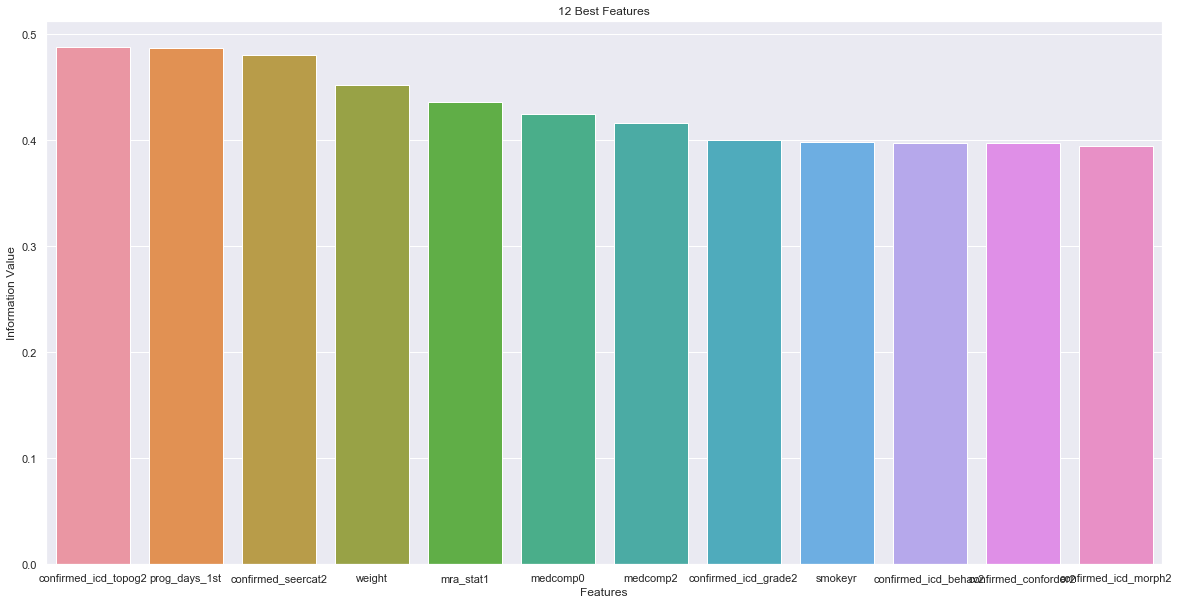

In [204]:
## Generate the feature-information value dataframe
# Reference: https://www.kaggle.com/emotionevil/category-features-selection-information-value
iv_df = pd.DataFrame()
iv_df['feature'] = feature_list
iv_df['IV'] = feature_iv_list
iv_df = iv_df.sort_values(by='IV', ascending=False)


# IV< 0.02: not useful for prediction
# 0.02 < IV < 0.1: weak predictive power
# 0.1 < IV < 0.3: medium predictive power
# 0.3 < IV < 0.5: strong predictive power
# IV> 0.5: suspicious predictive power

print("Best Features: ")
iv_df = iv_df[(iv_df['IV'] >= 0.3) & (iv_df['IV'] <= 0.5)]
print(iv_df)

# Plot the 12 best features 
f, ax = plt.subplots(figsize=(20, 10))
sns.set(style="darkgrid")
sns.barplot(x=iv_df.feature, y=iv_df.IV)

ax.set_title('12 Best Features')
ax.set_ylabel('Information Value')
ax.set_xlabel('Features')


In [6]:
### Using the best features found above to find the best model 
df = pd.read_csv("nlst_selected_1658_full.csv", header = 0, index_col = None)
target = df['class']

features = df[['prog_days_1st', 'confirmed_seercat2', 'weight', 'mra_stat1', 
               'medcomp0', 'medcomp2', 'confirmed_icd_grade2', 'smokeyr', 'confirmed_icd_behav2',
              'confirmed_conforder2', 'confirmed_icd_morph2']]

# filling blank cells with the means 
fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=1)
imputed_features = pd.DataFrame(fill_NaN.fit_transform(features))
imputed_features.columns = features.columns
imputed_features.index = features.index

In [28]:
# Method 1: decision tree method 
# split the data into train data and test dat 
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(imputed_features, target, random_state = 0)

In [67]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_split = 0.3,  min_samples_leaf = 8, max_features = 10,
                            random_state = 0).fit(X_train_dt, y_train_dt)
tree_predicted = dt.predict(X_test_dt)
confusion = confusion_matrix(y_test_dt, tree_predicted)
print(confusion)

[[244   6]
 [ 78  87]]


In [68]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_dt, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_dt, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_dt, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_dt, tree_predicted)))

Accuracy: 0.80
Precision: 0.94
Recall: 0.53
F1: 0.67


In [85]:
# Method 2: gradient decision tree method 
# split the data into train data and test dat 
X_train_gdt, X_test_gdt, y_train_gdt, y_test_gdt = train_test_split(imputed_features, target, random_state = 0)

In [97]:
# gdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 3, random_state = 0).fit(X_train_gdt, y_train_gdt)
gdt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120, max_depth=4, 
                                 max_features='sqrt', subsample=0.8, random_state=10).fit(X_train_gdt, y_train_gdt)

tree_predicted = gdt.predict(X_test_gdt)
confusion = confusion_matrix(y_test_gdt, tree_predicted)
print(confusion)


[[233  17]
 [ 60 105]]


In [98]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_gdt, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_gdt, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_gdt, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_gdt, tree_predicted)))

Accuracy: 0.81
Precision: 0.86
Recall: 0.64
F1: 0.73


In [132]:
# Method 3: logistic regression method 
# split the data into train data and test dat 
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(imputed_features, target, random_state = 0)

In [140]:
lr = LogisticRegression(C=100).fit(X_train_lr, y_train_lr)
tree_predicted = lr.predict(X_test_lr)
confusion = confusion_matrix(y_test_lr, tree_predicted)
print(confusion)

[[241   9]
 [ 78  87]]


In [141]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_lr, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_lr, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_lr, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_lr, tree_predicted)))

Accuracy: 0.79
Precision: 0.91
Recall: 0.53
F1: 0.67


In [142]:
### Method4: xgboost
# split the data into train data and test dat 
X_train_xgb, X_test_xgb,  y_train_xgb, y_test_xgb = train_test_split(imputed_features, target, random_state = 0)

In [179]:
params = {'objective': 'multi:softmax',
        'n_estimators': 5000,
        'learning_rate': 0.001,
        'max_depth': 5,
        'gamma': 0,
        'silent': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'colsample_bylevel': 1.0,
        'seed': 589309673,
        'reg_lambda': 1,
        'reg_alpha': 1,
        'nthread': 4,
        'scale_pos_weight': 1,
        'num_class':3
}

In [180]:
model = xgb.XGBClassifier(**params)
model.fit(X_train_lr, y_train_lr, eval_metric='mlogloss')
tree_predicted = model.predict(X_test_lr)
confusion = confusion_matrix(y_test_lr, tree_predicted)
print(confusion)

[[230  20]
 [ 60 105]]


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [181]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test_xgb, tree_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test_xgb, tree_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test_xgb, tree_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test_xgb, tree_predicted)))

Accuracy: 0.81
Precision: 0.84
Recall: 0.64
F1: 0.72
